# Winner Takes All Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dynamical Equation Definitions
    
def F(I, a=270, b=108, d=0.154):
    '''
    rate [Hz] as a function of total input current [nA]
    '''
    return (a*I - b)/(1 - np.exp(-d*(a*I - b)))

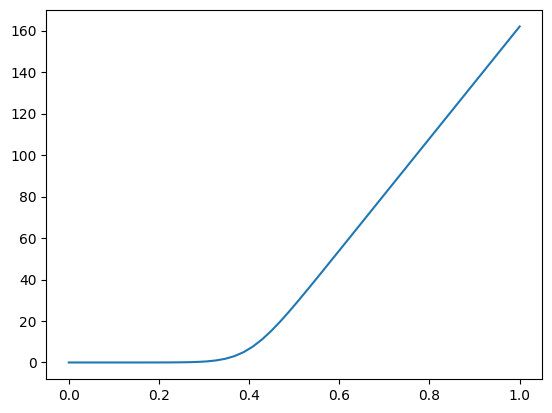

In [4]:
I = np.linspace(0,1)
plt.plot(I, F(I))

In [5]:
def default_params( **kwargs):
    pars = {}
    
    ### gain variables ###
    pars['a'] = 270.   # Gain of the E population
    pars['b'] = 108.   # Threshold of the E population
    pars['d'] = 0.154
    
    ### synaptic parameters ###
    pars['tauS']  = 0.1   # Timescale of the E population [sec]
    pars['gamma'] = 0.641  # Saturation factor for gating variable 

    ### Connection strength ###
    pars['JE'] = 0.2609 # local self-coupling strength [nA]
    pars['JI'] = -0.0497 # local cross-coupling strength [nA]
    
    ### background input####
    pars['Ib1'] = 0.3255 # background current [nA]
    pars['Ib2'] = 0.3255 # background current [nA]
    ### OU background noise ###
    pars['tau0'] = 0.002 # Noise time constant [sec]
    pars['sigma'] = 0.02 # Noise magnitude [nA]
    pars['myseed'] = None

    ### simulation parameters ###
    pars['T']         = 5. # Total duration of simulation [sec]
    pars['dt']        = 0.0005 # Simulation time step [sec]
    pars['dt_smooth'] = 0.02 # Temporal window size for smoothing [sec]
    pars['s1_init'] = 0.0 # Initial value of s1, low hierarchy
    pars['s2_init'] = 0.0 # Initial value of s2, high hierarchy
    
    ### Stimulus Parameters ###
    pars['Jext'] = 5.2e-4 # Stimulus input strength [nA]
    pars['mu0']  = 30 #20.    # Strength of stimulus 1 [dimensionless]
    pars['mu1'] = 20
    pars['mu2'] = 80
    pars['coh'] = 0
    pars['Ntrials'] = 5   # Total number of trials
    pars['Tstim'] = 1.    # Time of stimulus 1 onset [sec]
    pars['Tdur'] = 2.     # Duration of stimulus 1 [sec]

    return pars

In [6]:
def run_sim(pars, verbose=False):
    '''
    Run simulation, for multiple trials.
    
    Parameters:
    pars : circuit model parameters
    
    Return: dictionary with activity traces
    '''
    # retivial parameters
    ### gain variables ###
    a, b, d = pars['a'], pars['b'], pars['d']
    
    ### synaptic parameters ###
    tauS, gamma = pars['tauS'], pars['gamma']

    ### Connection strength ###
    JE, JI = pars['JE'], pars['JI']
    
    ### background input####
    Ib1, Ib2 = pars['Ib1'], pars['Ib2']
    ### OU background noise ###
    tau0, sigma, myseed = pars['tau0'], pars['sigma'], pars['myseed']

    ### simulation parameters ###
    T, dt, dt_smooth = pars['T'], pars['dt'], pars['dt_smooth']
    s1_init, s2_init = pars['s1_init'], pars['s2_init']
    
    ### Stimulus Parameters ###
    Jext, mu1, mu2 = pars['Jext'], pars['mu1'], pars['mu2']
    Ntrials, Tstim, Tdur = pars['Ntrials'], pars['Tstim'], pars['Tdur']
    
    range_t = int(T/dt)
    NT = len(range_t)
    
    # Make lists to store firing rate (r) and gating variable (s)
    S1_traj = []  
    S2_traj = []
    r1_traj = []  
    r2_traj = []
    r1smooth_traj = []  
    r2smooth_traj = []
    
    verb_trial = max(int(Ntrials/10), 1)
    
    for i in range(Ntrials): #Loop through trials

        if verbose and (i % verb_trial == 0):
            print("trial # ", i+1, 'of', Ntrials)

        #Set random seed
#         np.random.seed(i)
        gwn = np.random.randn(NT, 2)

        #Initialize
        r1smooth = []
        r2smooth = []
        
        Ieta1 = np.zeros(NT+1)
        Ieta2 = np.zeros(NT+1)
        S1 = np.zeros(NT+1)
        S2 = np.zeros(NT+1)
        r1 = np.zeros(NT)
        r2 = np.zeros(NT)
        
        # Initialize S1, S2
        S1[0], S2[0] = s1_init, s2_init
        
        for t in range(NT): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------
            Istim1 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu1) # To population 1
            Istim2 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu2) # To population 2
                 
            # Total synaptic input
            Isyn1 = JE*S1[t] + JI*S2[t] + Istim1 + Ieta1[t]
            Isyn2 = JI*S1[t] + JE*S2[t] + Istim2 + Ieta2[t]
            
            # Transfer function to get firing rate
            r1[t]  = F(Isyn1, a, b, d)
            r2[t]  = F(Isyn2, a, b, d)
        
            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1[t+1] = S1[t] + dt*(-S1[t]/tauS + (1-S1[t])*gamma*r1[t]);
            S2[t+1] = S2[t] + dt*(-S2[t]/tauS + (1-S2[t])*gamma*r2[t]);

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1[t+1] = Ieta1[t] + (dt/tau0) * (Ib1-Ieta1[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 0]
            Ieta2[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 1]
        
        smooth_wind = int(dt_smooth/dt)
        
        r1smooth = np.array([np.mean(r1[j:j+smooth_wind]) for j in range(NT)])
        r2smooth = np.array([np.mean(r2[j:j+smooth_wind]) for j in range(NT)])
        
        S1_traj.append(S1)
        S2_traj.append(S2)
        r1_traj.append(r1)
        r2_traj.append(r2)
        r1smooth_traj.append(r1smooth)
        r2smooth_traj.append(r2smooth)
    
    z = {'S1':np.array(S1_traj), 'S2':np.array(S2_traj), # NMDA gating variables
         'r1':np.array(r1_traj), 'r2':np.array(r2_traj), # Firing rates
         'r1smooth':np.array(r1smooth_traj), 'r2smooth':np.array(r2smooth_traj), # smoothed firing rates
         't':range_t}

    return z

### Plotting nullclines

Setting the dynamical equations equal to zero, we get that 

In [7]:
def Nullcline_S1(pars, I1, fixed_range=True, ifstim = True):
    """
    Obtain nullcline S1 from equation (3)
    """
    a, b, d = pars['a'], pars['b'], pars['d']
    JE, JI = pars['JE'], pars['JI']
    gamma, tauS = pars['gamma'], pars['tauS']
    Jext, mu0, Ib1 = pars['Jext'], pars['mu0'], pars['Ib1']
    Istim = ifstim*(Jext*mu0)*(1 - p['coh']/100)
    
    S1 = gamma*F(I1, a, b, d) / (gamma*F(I1, a, b, d) + 1./tauS)
    S2 = (I1 - JE*S1 - Ib1 - Istim) / JI
    if fixed_range:
        id_range = (S2>=-0.0) &(S2<=1.2)
    else:
        id_range = S2<=1e5
    
    return S1[id_range], S2[id_range]

In [8]:
def Nullcline_S2(pars, I2, fixed_range=True, ifstim = True):
    """
    Obtain nullcline S1 from equation (3)
    """
    a, b, d = pars['a'], pars['b'], pars['d']
    JE, JI = pars['JE'], pars['JI']
    gamma, tauS = pars['gamma'], pars['tauS']
    Jext, mu0, Ib2 = pars['Jext'], pars['mu0'], pars['Ib2']
    Istim = ifstim*(Jext*mu0)*(1 - p['coh']/100)
    
    S2 = gamma*F(I2, a, b, d) / (gamma*F(I2, a, b, d) + 1./tauS)
    S1 = (I2 - JE*S2 - Ib2 - Istim) / JI
    if fixed_range:
        id_range = (S1>=-0.0) &(S1<=1.2)
    else:
        id_range = S1<=1e5
    
    return S1[id_range], S2[id_range]

-0.0497


TypeError: 'AxesSubplot' object is not subscriptable

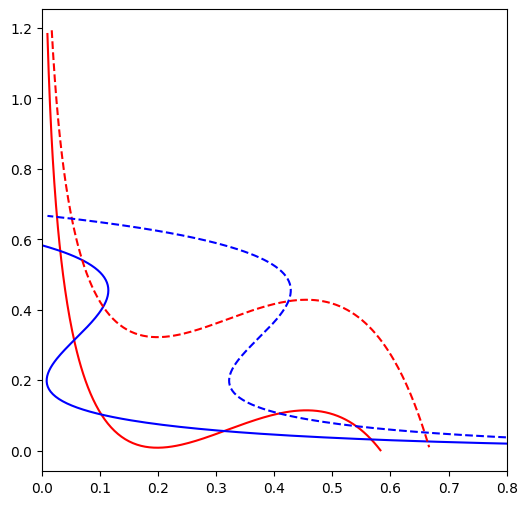

In [9]:
p = default_params()

print(p['JI'])

I1 = np.linspace(0, 1, 1000)
I2 = np.linspace(0, 1, 1000)
s1_1, s2_1= Nullcline_S1(p, I1, ifstim = False, fixed_range=True)
s1_2, s2_2 = Nullcline_S2(p, I2, ifstim = False, fixed_range=True)
s1_1_stim, s2_1_stim = Nullcline_S1(p, I1, ifstim = True, fixed_range=True)
s1_2_stim, s2_2_stim = Nullcline_S2(p, I2, ifstim = True, fixed_range=True)

fig, axs = plt.subplots(figsize = (6,6),sharex = True, sharey = True, dpi = 100)
axs.plot(s1_1, s2_1, 'r', label = "S1 nullcline")
axs.plot(s1_2, s2_2, 'b', label = "S2 nullcline")
axs.plot(s1_1_stim, s2_1_stim, 'r', ls = '--', label = "S1 nullcline")
axs.plot(s1_2_stim, s2_2_stim, 'b', ls = '--', label = "S2 nullcline")

plt.xlim([0, 0.8])
axs[0].ylim([0, 0.8])
#axs[0].legend()
plt.tight_layout()
plt.savefig("plots/wongwangattractors.png")

# Changing cross inhibition

In [10]:
def Modified_Nullcline_S1(pars, I1, fixed_range=True, ifstim = True):
    """
    Obtain nullcline S1 from equation (3)
    """
    a, b, d = pars['a'], pars['b'], pars['d']
    JE, JI = pars['JE'], pars['JI']
    gamma, tauS = pars['gamma'], pars['tauS']
    Jext, mu0, Ib1 = pars['Jext'], pars['mu0'], pars['Ib1']
    Istim = ifstim*(Jext*mu0)*(1 - p['coh']/100)
    
    S1 = gamma*F(I1, a, b, d) / (gamma*F(I1, a, b, d) + 1./tauS)
    S2 = (I1 - JE*S1 - Ib1 - Istim) / JI
    if fixed_range:
        id_range = (S2>=-0.0) &(S2<=1.2)
    else:
        id_range = S2<=1e5
    
    return S1[id_range], S2[id_range]

## Add a dendritic modification

In [11]:
def f_r(I):
    # I is the sum of input from dendrites and from somatic inhibition
    # This was a fitted function
    return (np.max(0,I+174.86)/45.16)**2.89

def I_d_s(gE, gI):
    V_0 = 0.78      # mV
    E_L = -70       # mV
    bg = 5.56
    k = 9.64        # nS
    gamma = 6.54    # nS
    gLD = 4.0         # nS (dendritic leak conductance)
    Gc = 8.         # nS (total dendritic-soma coupling)
    beta = k * np.exp(gI/gamma)
    g12 = bg * (gLD + gI)

    # calculate dendritic voltage
    VD = 30 * (1 + np.tanh((gE - g12)/beta)) + V_0 + E_L

    # current into soma from the dendrites
    I = Gc * (VD - E_L)

    return I, VD

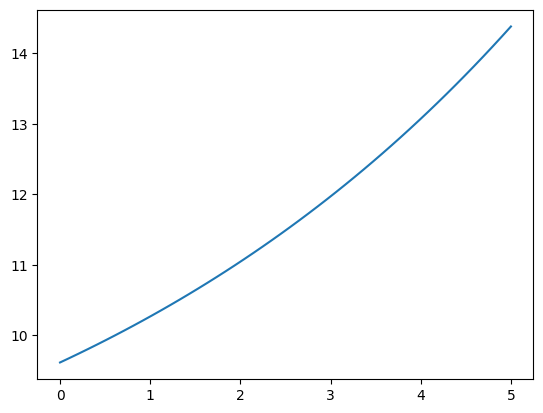

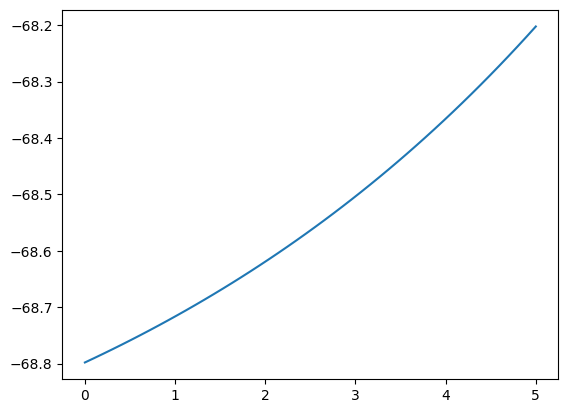

In [12]:
g_array = np.linspace(0, 5)
I, VD = I_d_s(g_array, 1)
plt.plot(g_array, I)
plt.subplots()
plt.plot(g_array, VD)

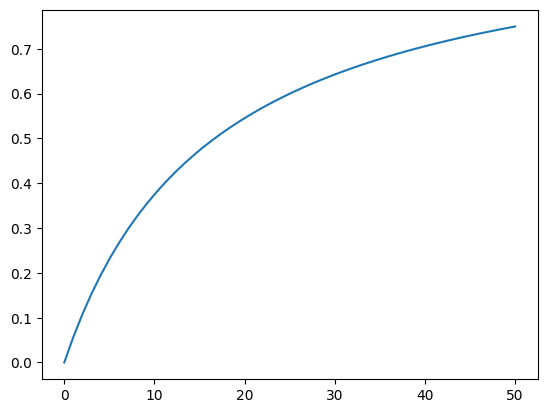

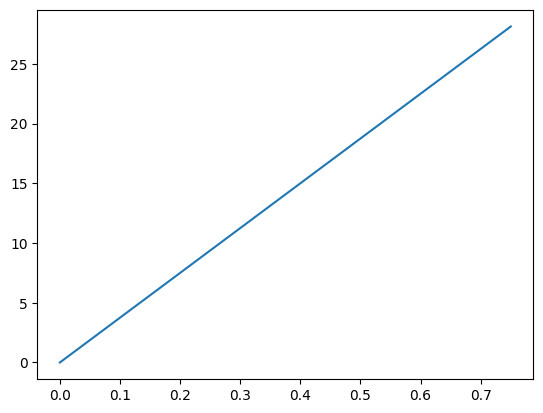

In [13]:
# For inputs to the rate model, gE and gI are the time-averaged total conductance of all excitatory and inhibitory synapses, respectively.

def sNMDA(rE):
    # rE is the input rate in Hz
    alpha_NMDA      = 0.3   # ms^-1
    tau_NMDA_rise   = 2     # ms
    tau_NMDA_decay  = 100   # ms
    return 1 - (1 + 0.001*rE*tau_NMDA_rise*tau_NMDA_decay*alpha_NMDA)**-1 

rE = np.linspace(0, 50)
plt.plot(rE, sNMDA(rE))


def gE(sNMDA):
    gNMDA = 2.5 # nS
    nNMDA = 15
    return nNMDA * sNMDA * gNMDA

def gI(rI):
    tauGABA = 20 # ms (fr dendrite targeting inhibitory synapses)
    gGABA   = 4. # nS
    return 0.001 * rI * gGABA * tauGABA

plt.subplots()
plt.plot(sNMDA(rE), gE(sNMDA(rE)))

In [3]:
def run_sim_dend(pars, verbose=False):
    '''
    Run simulation, for multiple trials.
    
    Parameters:
    pars : circuit model parameters
    
    Return: dictionary with activity traces
    '''
    # retivial parameters
    ### gain variables ###
    a, b, d = pars['a'], pars['b'], pars['d']
    
    ### synaptic parameters ###
    tauS, gamma = pars['tauS'], pars['gamma']

    ### Connection strength ###
    JE, JI = pars['JE'], pars['JI']
    
    ### background input####
    Ib1, Ib2 = pars['Ib1'], pars['Ib2']
    ### OU background noise ###
    tau0, sigma, myseed = pars['tau0'], pars['sigma'], pars['myseed']

    ### simulation parameters ###
    T, dt, dt_smooth = pars['T'], pars['dt'], pars['dt_smooth']
    s1_init, s2_init = pars['s1_init'], pars['s2_init']
    
    ### Stimulus Parameters ###
    Jext, mu1, mu2 = pars['Jext'], pars['mu1'], pars['mu2']
    Ntrials, Tstim, Tdur = pars['Ntrials'], pars['Tstim'], pars['Tdur']
    
    NT = int(T/dt)
    
    # Make lists to store firing rate (r) and gating variable (s)
    S1_traj = []  
    S2_traj = []
    r1_traj = []  
    r2_traj = []
    r1smooth_traj = []  
    r2smooth_traj = []
    
    verb_trial = max(int(Ntrials/10), 1)
    
    for i in range(Ntrials): #Loop through trials

        if verbose and (i % verb_trial == 0):
            print("trial # ", i+1, 'of', Ntrials)

        #Set random seed
#         np.random.seed(i)
        gwn = np.random.randn(NT, 2)

        #Initialize
        r1smooth = []
        r2smooth = []
        
        Ieta1 = np.zeros(NT+1)
        Ieta2 = np.zeros(NT+1)
        IetaPV = np.zeros(NT+1)
        S1 = np.zeros(NT+1)
        S2 = np.zeros(NT+1)
        SPV = np.zeros(NT+1)
        r1 = np.zeros(NT)
        r2 = np.zeros(NT)
        rPV = np.zeros(NT)
        
        # Initialize S1, S2
        S1[0], S2[0] = s1_init, s2_init
        
        for t in range(NT): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------
            Istim1 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu1) # To population 1
            Istim2 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu2) # To population 2

            # PV inhibiton (constant)
            IPV = JI*0.5
                 
            # Total synaptic input
            IDS_1 = I_d_s(gE(S1), 0.01)
            IDS_2 = I_d_s(gE(S2), 0.01)
            Isyn1 = IDS_1[t] + IPV + Istim1 + Ieta1[t]
            Isyn2 = IDS_2[t] + IPV + IPV + Istim2 + Ieta2[t]

            # Transfer function to get firing rate
            r1[t]  = F(IDS_1, a, b, d)
            r2[t]  = F(IDS_2, a, b, d)
        
            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1[t+1] = S1[t] + dt*(-S1[t]/tauS + (1-S1[t])*gamma*r1[t]);
            S2[t+1] = S2[t] + dt*(-S2[t]/tauS + (1-S2[t])*gamma*r2[t]);

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1[t+1] = Ieta1[t] + (dt/tau0) * (Ib1-Ieta1[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 0]
            Ieta2[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 1]
        
        smooth_wind = int(dt_smooth/dt)
        
        r1smooth = np.array([np.mean(r1[j:j+smooth_wind]) for j in range(NT)])
        r2smooth = np.array([np.mean(r2[j:j+smooth_wind]) for j in range(NT)])
        
        S1_traj.append(S1)
        S2_traj.append(S2)
        r1_traj.append(r1)
        r2_traj.append(r2)
        r1smooth_traj.append(r1smooth)
        r2smooth_traj.append(r2smooth)
    
    z = {'S1':np.array(S1_traj), 'S2':np.array(S2_traj), # NMDA gating variables
         'r1':np.array(r1_traj), 'r2':np.array(r2_traj), # Firing rates
         'r1smooth':np.array(r1smooth_traj), 'r2smooth':np.array(r2smooth_traj), # smoothed firing rates
         't':range_t}

    return z

run_sim_dend(default_params())

NameError: name 'default_params' is not defined

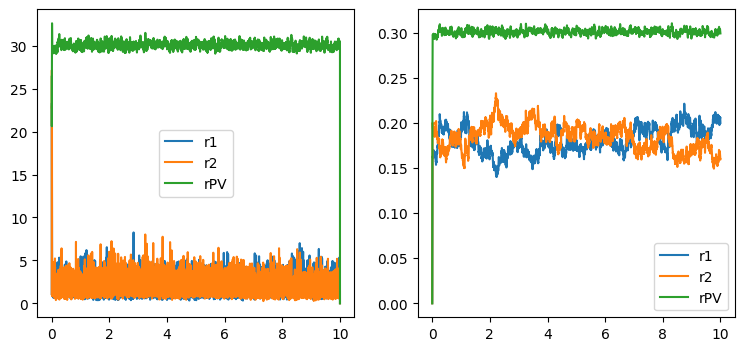

In [32]:
def run_threepop():
    '''
    Note that for unit consistency, all units are
    time [s]
    current [nA]

    '''
    # --- params ----
    T = 10. #s
    dt = 0.0005 #s
    
    # gating variables
    S1_init = 0
    S2_init = 0
    SPV_init = 0

    # coupling constants
    Jr = 0.2409      # nA
    Jc = 0.03
    Jei = 0.5
    Jie = -1.2
    Jii = -0.55

    # Interneuron FI slopes
    betaPV = 220 # Hz/nA

    # background
    Ie_1 = Ie_2 = 0.3294
    Ie_PV = 0.12

    # stimulus
    NT = int(T/dt)
    timerange = np.linspace(0,T, NT)

    # --- run sim ---

    # // Initialize //
    # Gating Variables
    S1 = S1_init*np.ones(NT)
    S2 = S2_init*np.ones(NT)
    SPV = SPV_init*np.ones(NT)
    tauN = 90.*1e-3  # s
    tauG = 5.*1e-3   # s
    gamma = 1.282
    gamma_I = 2. 

    # Noise
    Ieta1 = np.zeros(NT)
    Ieta2 = np.zeros(NT)
    IetaPV = np.zeros(NT)
    
    # rates
    R1 = np.zeros(NT)
    R2 = np.zeros(NT)
    RPV = np.zeros(NT)

    # noise
    tau_eta = 2*1e-3 # s
    sigma_1 = sigma_2 = 0.02 #nA
    sigma_PV = 0

    # run
    for t_idx, t in enumerate(timerange[:-1]):
        # Stimulus
        I_stim1 = 0
        I_stim2 = 0

        # Calculate synaptic input
        I1 = Jr*S1[t_idx] + Jc*S2[t_idx] + Jie*SPV[t_idx] + Ie_1 + Ieta1[t_idx] + I_stim1
        I2 = Jc*S1[t_idx] + Jr*S2[t_idx] + Jie*SPV[t_idx] + Ie_2 + Ieta2[t_idx] + I_stim2
        IPV = Jei*S1[t_idx] + Jei*S2[t_idx] + Jii*SPV[t_idx] + Ie_PV + IetaPV[t_idx]

        # Transfer function
        R1[t_idx] = F(I1)
        R2[t_idx] = F(I2)

        # Interneuron firing rate
        RPV[t_idx] = betaPV*IPV

        # OU noise
        Ieta1[t_idx+1] = Ieta1[t_idx] + (dt/tau_eta)*(Ie_1-Ieta1[t_idx]) + np.sqrt(dt/tau_eta)*sigma_1*np.random.randn()
        Ieta2[t_idx+1] = Ieta2[t_idx] + (dt/tau_eta)*(Ie_2-Ieta2[t_idx]) + np.sqrt(dt/tau_eta)*sigma_2*np.random.randn()
        IetaPV[t_idx+1] = IetaPV[t_idx] + (dt/tau_eta)*(-IetaPV[t_idx]) + np.sqrt(dt/tau_eta)*sigma_PV*np.random.randn()

        # Update gating
        S1[t_idx+1] = S1[t_idx] + dt*(-S1[t_idx]/tauN + (1 - S1[t_idx])*gamma*R1[t_idx])
        S2[t_idx+1] = S2[t_idx] + dt*(-S2[t_idx]/tauN + (1 - S2[t_idx])*gamma*R2[t_idx])
        SPV[t_idx+1] = SPV[t_idx] + dt*(-SPV[t_idx]/tauG + gamma_I*RPV[t_idx])

    data = {
        't': timerange,
        'R1':  R1,
        'R2':  R2,
        'RPV': RPV,
        'S1':   S1,
        'S2':   S2,
        'SPV': SPV
    }

    return data

data = run_threepop()

fig, axs = plt.subplots(1,2, figsize=(9,4))

axs[0].plot(data['t'], data['R1'], label='r1')
axs[0].plot(data['t'], data['R2'], label='r2')
axs[0].plot(data['t'], data['RPV'], label='rPV')
axs[0].legend()

axs[1].plot(data['t'], data['S1'], label='r1')
axs[1].plot(data['t'], data['S2'], label='r2')
axs[1].plot(data['t'], data['SPV'], label='rPV')
axs[1].legend()

